# EDAの結果メモ

## Summary:

### 参考データ：
* [東京都中央卸売市場日報](https://www.shijou-nippo.metro.tokyo.lg.jp/)
* [気象庁より気象情報](https://www.data.jma.go.jp/obd/stats/etrn/)
* 

### Points
* どの時点での気象が影響する可能性があるのか
* 気象情報をどのようにデータに入れていくのか
  * step1：全国平均 + (北海道・千葉・神奈川・茨城・青森) を変数に入れる
  * step2：産地の組み合わせパターンを変数に入れる
  * step3：各産地で価格の予測を行う


### Knowledge
* trainのみに含まれる野菜がある


In [370]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('font', family='BIZ UDGothic')

import pandas as pd

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


In [371]:
WorkPath = "../data/"
train_df = pd.read_csv(WorkPath + 'train.csv')
test_df = pd.read_csv(WorkPath + 'test.csv')
weather = pd.read_csv(WorkPath + 'weather.csv')

### 各日付で各野菜は1種類のみ提示

In [414]:
# 日付と野菜種類でグループ化 -> カウント数が1以外の物はない（重複報告がない）ことを確認
(train_df.groupby(['date', 'kind']).count() != 1).sum()

amount        0
mode_price    0
area          0
dtype: int64

### 野菜の種類

In [372]:
print("訓練データの野菜の種類：" + str(len(set(train_df.kind))))
print("検証データの野菜の種類：" + str(len(set(test_df.kind))))
common_set = set(train_df.kind)&set(test_df.kind)
print("共通野菜種類：" + str(len(common_set)))
print(common_set)

# 以下では共通の野菜のみを分析対象にする
train_df = train_df[train_df.kind.isin(common_set)].reset_index(drop=True).sort_values(by = 'date')

# datetimeに変換
train_df.date = pd.to_datetime(train_df.date.astype(str))
weather.date = pd.to_datetime(weather.date.astype(str))

訓練データの野菜の種類：44
検証データの野菜の種類：16
共通野菜種類：16
{'レタス', 'そらまめ', 'にんじん', 'ミニトマト', 'ねぎ', 'じゃがいも', 'こまつな', 'はくさい', 'ピーマン', 'だいこん', 'キャベツ', 'なましいたけ', 'ほうれんそう', 'トマト', 'きゅうり', 'セルリー'}


### 欠損状況の確認

In [373]:
# 訓練データに欠損はない
train_df.isna().sum()

kind          0
date          0
amount        0
mode_price    0
area          0
dtype: int64

### 野菜の値段感

In [374]:
MeanPriceRank = train_df.groupby('kind')['mode_price'].mean().sort_values(ascending=False)
MaxPriceRank = train_df.groupby('kind')['mode_price'].max().sort_values(ascending=False)
MinPriceRank = train_df.groupby('kind')['mode_price'].min().sort_values(ascending=False)
RangePriceRank = (
    train_df.groupby('kind')['mode_price'].max() - train_df.groupby('kind')['mode_price'].min()
    ).sort_values(ascending=False)

pd.DataFrame({
    "平均値段ランキング：" :MeanPriceRank.index + ':' + MeanPriceRank.astype(str).values,
    "最高値段ランキング：": MaxPriceRank.index + ':' + MaxPriceRank.astype(str).values,
    "最低値段ランキング：": MinPriceRank.index + ':' + MinPriceRank.astype(str).values,
    "値段幅ランキング：": RangePriceRank.index + ':' + RangePriceRank.astype(str).values
    })

,平均値段ランキング：,最高値段ランキング：,最低値段ランキング：,値段幅ランキング：
0,セルリー:2584.674410698096,レタス:7776.0,セルリー:1155.0,レタス:7487.0
1,じゃがいも:2096.550217093236,ねぎ:7087.5,そらまめ:630.0,ねぎ:6547.5
2,そらまめ:2067.8519924098673,セルリー:5832.0,ねぎ:540.0,じゃがいも:4875.0
3,レタス:1792.3067481160083,じゃがいも:5400.0,きゅうり:525.0,セルリー:4677.0
4,きゅうり:1667.792760904316,きゅうり:5040.0,じゃがいも:525.0,にんじん:4548.0
5,ねぎ:1664.451415848367,にんじん:4968.0,トマト:525.0,きゅうり:4515.0
6,トマト:1446.9753368348938,はくさい:4104.0,だいこん:420.0,はくさい:3789.0
7,にんじん:1434.4553612254228,そらまめ:3990.0,にんじん:420.0,そらまめ:3360.0
8,はくさい:1095.4352021009363,トマト:3564.0,はくさい:315.0,キャベツ:3141.0
9,キャベツ:965.657113496232,キャベツ:3456.0,キャベツ:315.0,トマト:3039.0


Text(0.5, 1.0, '値動きの大きい野菜 Top5')

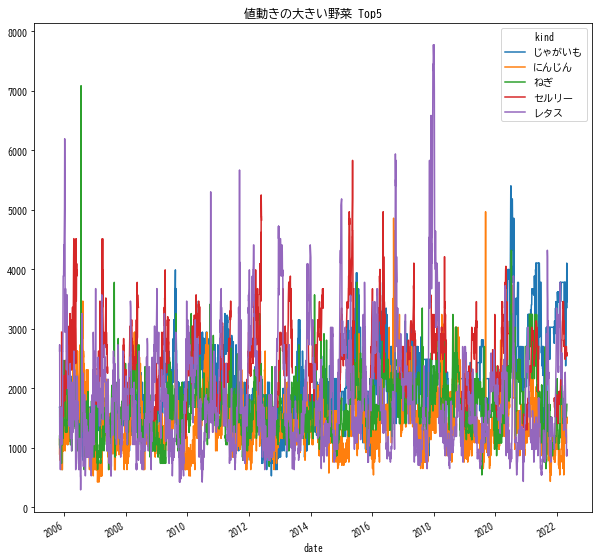

In [375]:
from matplotlib.pyplot import legend
train_df[train_df.kind.isin(RangePriceRank.index[:5])].pivot_table(
    values= 'mode_price', 
    index='date', 
    columns='kind'
    ).plot.line(figsize=(10,10))
plt.title('値動きの大きい野菜 Top5')

## 気象情報の利用

In [376]:
# 各野菜に登場するエリア情報
# （基本的には北海道・千葉・神奈川・茨城・青森の5つ + 全国）
pd.DataFrame({
    k : sorted(set(pd.Series(train_df[train_df.kind == "だいこん"].area.unique()).str.split("_").sum())) 
    for k in set(train_df.kind)
    }).T


,0,1,2,3,4,5
レタス,北海道,千葉,各地,神奈川,茨城,青森
そらまめ,北海道,千葉,各地,神奈川,茨城,青森
にんじん,北海道,千葉,各地,神奈川,茨城,青森
ミニトマト,北海道,千葉,各地,神奈川,茨城,青森
セルリー,北海道,千葉,各地,神奈川,茨城,青森
ねぎ,北海道,千葉,各地,神奈川,茨城,青森
じゃがいも,北海道,千葉,各地,神奈川,茨城,青森
ピーマン,北海道,千葉,各地,神奈川,茨城,青森
こまつな,北海道,千葉,各地,神奈川,茨城,青森
はくさい,北海道,千葉,各地,神奈川,茨城,青森


### 欠損状況

In [377]:
weather.isna().sum()

date               0
mean_temp        367
max_temp         367
max_temp_time    367
min_temp         368
min_temp_time    368
sum_rain         369
sun_time         432
mean_humid       398
area               0
dtype: int64

In [378]:
# 欠損補完（ベイジアンブリッジ）
weather = pd.concat(
    [
        pd.DataFrame(
            IterativeImputer().fit_transform(weather.select_dtypes(float).to_numpy()),
            columns = weather.head().select_dtypes(float).columns
            ),
        weather.select_dtypes(exclude=float)
    ],
    axis = 1
    )

### 接続に利用するキー（エリア名）の確認

In [379]:
# 県名で入っているケースは少ない
print(set(weather.area))

{'高知', '秋田', '長崎', '山形', '神戸', '盛岡', '仙台', '千葉', '名古屋', '松山', '浜松', '青森', '徳島', '東京', '前橋', '和歌山', '那覇', '熊谷', '福岡', '宇都宮', '横浜', '佐賀', '甲府', '帯広', '福島', '長野', '高松', '鹿児島', '宮崎', '熊本', '新潟', '水戸'}


In [380]:
AllRegionAVG = weather.drop(columns=['area', 'min_temp_time', 'max_temp_time']).groupby("date").mean()
AllRegionMAX = weather.drop(columns=['area', 'min_temp_time', 'max_temp_time']).groupby("date").max()
AllRegionMIN = weather.drop(columns=['area', 'min_temp_time', 'max_temp_time']).groupby("date").min()

AllRegionAVG.set_axis("AVG_" + AllRegionAVG.columns, axis =1, inplace=True)
AllRegionMAX.set_axis("MAX_" + AllRegionMAX.columns, axis =1, inplace=True)
AllRegionMIN.set_axis("MIN_" + AllRegionMIN.columns, axis =1, inplace=True)

AllRegionInfo = pd.concat([
    AllRegionAVG,
    AllRegionMAX,
    AllRegionMIN
], axis =1)

In [385]:
# 各地、全国の気象情報
RegionInfo = pd.concat(
    [
    weather[
        weather.area.isin(["帯広", "千葉", "横浜", "水戸", "青森"])
        ]
    .pivot_table(values = col_name, index ='date', columns = 'area')
    .set_axis(
        col_name + '_'+ pd.Series(["北海道", "千葉", "神奈川", "茨城", "青森"]), 
        axis = 1
        ) for col_name in weather.head().select_dtypes(include='float').columns
    ] + [AllRegionInfo], # 全国の情報も追加,
    axis=1
    )

In [401]:
# 訓練データに気象情報をマージ
train = pd.merge(train_df.set_index('date'), RegionInfo, left_index = True, right_index = True, how = 'left')

# マージの確認
if (train.index != train_df.set_index('date').index).sum() == 0:
    print("マージ成功")

マージ成功


# 加工済みデータを保存

In [416]:
train.to_csv('../data/processed_train_df.csv', encoding = 'SHIFT-JIS')